In [395]:
import numpy as np
import pandas as pd
import scipy.stats as st
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
%matplotlib inline
import datetime
import time
import copy
import re

title = 'woplus'
path = '../../sources/data'

In [2]:
df_talklen = pd.read_table('{}/dataset_2015_filter_talklen.txt'.format(path), sep='|')
df_talklen.head()

,imsi,mon,talklen
0,3467b78c398e0fc47653d11004d7a3f4,201511,3
1,bad4c4e99f3a9aa638fe5f1cbd4324c6,201506,0
2,5d75b3dae18ec07dc75c09e92607acf2,201512,64
3,419c844c916c053cb5a55f1095966fb5,201508,478
4,ef32199109a31f7635c2de3c3942ce33,201507,0


In [6]:
# 1. pivot
df_talklen.pivot(index='imsi', columns='mon').iloc[:10]
# 2. unstack

# 3. stack

talklen                                     \
mon                               201501 201502 201503 201504 201505 201506   
imsi                                                                          
00002ec9f6870677ca801c213ce87c02     346    316    416    423    359    315   
0000be0fbdbe7f8ff47f7ec3e077e489      87     94    109     96     92    110   
000166f550781551e1eb11cfcd3f4267      24     18     24     38     51     47   
0001a48e7fca2e7e3279a5f275525cdb     143    259    171    161    143    155   
0001b4ebaa72f0e4c2e79a0791bf3002       5     22     16     16      4     11   
0001f2eb5ad30a34a0cb941192964cfc    4431   4838   2870   2068   1847   1844   
0001fed08450fb44b8b640531199fdf1       0      0      0      0      0      0   
00026c98750cd2612a469f5c8d33256b     585   1186    336    276    268    386   
00027e33ff9ec80bfb286e097579c79e       0      0      0      0      0      0   
000289cbbc5816e328f4b2876d95a1bb      21      4     60     25     26     13   

                                                                            
mon                              201507 201508 201509 201510 201511 201512  
imsi                                                                        
00002ec9f6870677ca801c213ce87c02    451    480    465    456    208    249  
0000be0fbdbe7f8ff47f7ec3e077e489    128     61    127    148     55     63  
000166f550781551e1eb11cfcd3f4267     10      5     39     51      0      0  
0001a48e7fca2e7e3279a5f275525cdb    128    217    101     87     75     78  
0001b4ebaa72f0e4c2e79a0791bf3002      4      5     31     41     11      0  
0001f2eb5ad30a34a0cb941192964cfc   1288    659    725    359    574    620  
0001fed08450fb44b8b640531199fdf1      0      0      0      0      0      0  
00026c98750cd2612a469f5c8d33256b    399    472    193    238    166    210  
00027e33ff9ec80bfb286e097579c79e      0      0      0      0      0      0  
000289cbbc5816e328f4b2876d95a1bb      4     20      6      6      5      0

## Load Data
### Internal Data 赛题直接提供的内部数据

In [23]:
df_net = pd.read_table('{}/dataset_2015_filter_net.txt'.format(path), sep='|')
df_net_piv = df_net.pivot(index='imsi', columns='mon')
df_net_piv.columns = ['net01','net02','net03','net04','net05','net06','net07','net08','net09','net10','net11','net12']

df_age = pd.read_table('{}/dataset_2015_filter_age.txt'.format(path), sep='|')
df_age_piv = df_age.pivot(index='imsi', columns='mon')
df_age_piv.columns = ['age01','age02','age03','age04','age05','age06','age07','age08','age09','age10','age11','age12']

df_sex = pd.read_table('{}/dataset_2015_filter_sex.txt'.format(path), sep='|')
df_sex_piv = df_sex.pivot(index='imsi', columns='mon')
df_sex_piv.columns = ['sex01','sex02','sex03','sex04','sex05','sex06','sex07','sex08','sex09','sex10','sex11','sex12']

df_arpu = pd.read_table('{}/dataset_2015_filter_arpu.txt'.format(path), sep='|')
df_arpu_piv = df_arpu.pivot(index='imsi', columns='mon')
df_arpu_piv.columns = ['arpu01','arpu02','arpu03','arpu04','arpu05','arpu06','arpu07','arpu08','arpu09','arpu10','arpu11','arpu12']

df_stream = pd.read_table('{}/dataset_2015_filter_stream.txt'.format(path), sep='|')
df_stream_piv = df_stream.pivot(index='imsi', columns='mon')
df_stream_piv.columns = ['stream01','stream02','stream03','stream04','stream05','stream06','stream07','stream08','stream09','stream10','stream11','stream12']

df_sms = pd.read_table('{}/dataset_2015_filter_sms.txt'.format(path), sep='|')
df_sms_piv = df_sms.pivot(index='imsi', columns='mon')
df_sms_piv.columns = ['sms01','sms02','sms03','sms04','sms05','sms06','sms07','sms08','sms09','sms10','sms11','sms12']

df_talklen = pd.read_table('{}/dataset_2015_filter_talklen.txt'.format(path), sep='|')
df_talklen_piv = df_talklen.pivot(index='imsi', columns='mon')
df_talklen_piv.columns = ['talklen01','talklen02','talklen03','talklen04','talklen05','talklen06','talklen07','talklen08','talklen09','talklen10','talklen11','talklen12']

df_me = pd.read_table('{}/dataset_2015_filter_me.txt'.format(path), sep='|')
df_me_piv = df_me.pivot(index='imsi', columns='mon')
df_me_piv.columns = ['brand01','brand02','brand03','brand04','brand05','brand06','brand07','brand08','brand09','brand10','brand11','brand12',\
                     'type01','type02','type03','type04','type05','type06','type07','type08','type09','type10','type11','type12']

### External Data

In [7]:
# 加载新的终端库信息
df_tacinfo = pd.read_csv('{}/tacinfo_for_woplus_deal_utf8.csv'.format(path))
df_tacinfo.columns = ['brand','type','brandtype','sumusers','avgusers','prices','sales_date','iselder','isnetcard','ispad']
df_tacinfo = df_tacinfo.loc[:, ['brand','type','prices','sales_date','iselder','isnetcard','ispad']]
df_tacinfo.iselder = df_tacinfo.iselder.fillna(0)
df_tacinfo.isnetcard = df_tacinfo.isnetcard.fillna(0)
df_tacinfo.ispad = df_tacinfo.ispad.fillna(0)
df_tacinfo.prices = df_tacinfo.prices.fillna(0)
df_tacinfo.head()

,brand,type,prices,sales_date,iselder,isnetcard,ispad
0,Apple,iPhone 5S,2500.0,2013/9/1,0.0,0.0,0.0
1,Apple,iPhone 5,2000.0,2012/9/1,0.0,0.0,0.0
2,Apple,iPhone 4,500.0,2010/10/1,0.0,0.0,0.0
3,Apple,iPhone 4S,800.0,2011/10/1,0.0,0.0,0.0
4,Apple,iPhone 6 (A1586),3890.0,2014/9/1,0.0,0.0,0.0


In [12]:
print df_tacinfo[df_tacinfo.brand == '苹果'].head(2)
print df_tacinfo[df_tacinfo.brand == u'苹果'].head(2)

  brand   type  prices sales_date  iselder  isnetcard  ispad
6    苹果  A1429  2000.0   2012/9/1      0.0        0.0    0.0
7    苹果  A1586  3890.0   2014/9/1      0.0        0.0    0.0
Empty DataFrame
Columns: [brand, type, prices, sales_date, iselder, isnetcard, ispad]
Index: []


## Data Summary

In [13]:
def ValueCounts(das, nhead=5):
    tmp = pd.value_counts(das).reset_index().rename_axis({'index': das.name}, axis=1)
    value = pd.DataFrame(['Value {}'.format(x+1) for x in np.arange(nhead)], index=np.arange(nhead)).join(tmp.iloc[:, 0], how='left').set_index(0).T
    freq = pd.DataFrame(['Freq {}'.format(x+1) for x in np.arange(nhead)], index=np.arange(nhead)).join(tmp.iloc[:, 1], how='left').set_index(0).T
    nnull = das.isnull().sum()
    freqother = pd.DataFrame({das.name: [das.shape[0] - nnull - np.nansum(freq.values), nnull]}, index=['Freq Others','Freq NA']).T
    op = pd.concat([value, freq, freqother], axis=1)
    return op

def Summary(da):
    op = pd.concat([pd.DataFrame({'type':da.dtypes, 'nnullCount':da.notnull().sum(axis=0)}), da.describe().T.iloc[:, 1:],
          pd.concat(map(lambda i: ValueCounts(da.loc[:,i]), da.columns))], axis=1).loc[da.columns]
    op.index.name='columns'
    return op

In [191]:
# Category
# Summary(df_net_piv).T
Summary(df_age_piv).T
# Summary(df_sex_piv).T
# Summary(df_arpu_piv).T
# Summary(df_stream_piv).T
# Summary(df_me_piv).T

# Numerical
# Summary(df_sms_piv).T
# Summary(df_talklen_piv).T

columns,age01,age02,age03,age04,age05,age06,age07,age08,age09,age10,age11,age12
nnullCount,360698,360698,360698,360698,360698,360698,360698,360698,360698,360698,360698,360698
type,object,object,object,object,object,object,object,object,object,object,object,object
unique,9,9,9,9,9,9,9,9,9,9,9,9
top,30-39,30-39,30-39,30-39,30-39,30-39,30-39,30-39,30-39,30-39,30-39,30-39
freq,172854,172083,170785,169961,169018,168135,164238,156381,138424,133118,130308,127469
Value 1,30-39,30-39,30-39,30-39,30-39,30-39,30-39,30-39,30-39,30-39,30-39,30-39
Value 2,40-49,40-49,40-49,40-49,40-49,40-49,40-49,40-49,40-49,40-49,40-49,40-49
Value 3,50-59,50-59,50-59,50-59,50-59,50-59,50-59,50-59,50-59,50-59,50-59,50-59
Value 4,60以上,60以上,60以上,60以上,60以上,60以上,60以上,60以上,60以上,60以上,60以上,60以上
Value 5,26-29,26-29,26-29,26-29,26-29,26-29,26-29,26-29,26-29,26-29,26-29,26-29


In [63]:
# df_sms_piv[df_sms_piv.sms10 > 9000]
df_talklen_piv[df_talklen_piv.talklen10 > 10000]

columns,talklen01,talklen02,talklen03,talklen04,talklen05,talklen06,talklen07,talklen08,talklen09,talklen10,talklen11,talklen12
imsi,,,,,,,,,,,,
2f0e28e470279b6a4bf31874d3949375,0,6027,9626,0,11435,12196,9711,9139,8245,10595,0,9052
8c54e0dee70ddc36a15e2a976ec77d47,0,0,16,0,2372,6787,15101,14039,11631,12666,14780,14178


In [264]:
mon = '09'
# df_net_piv_sel     = dfSelCol(df_net_piv, mon)
df_age_piv_sel     = dfSelCol(df_age_piv, mon)
# df_sms_piv_sel     = dfSelCol(df_sms_piv, mon) 
# df_talklen_piv_sel = dfSelCol(df_talklen_piv, mon)
    
# deal with Category Features 逻辑特征ohc
# net_catbin = CattoBin(df_net_piv_sel)
# age_catbin = CattoBin(df_age_piv_sel)
# sex_catbin = CattoBin(df_sex_piv_sel)
# arpu_catbin = CattoBin(df_arpu_piv_sel)
# stream_catbin = CattoBin(df_stream_piv_sel)

In [271]:
df_age_piv_sel.iloc[:,0].value_counts()
age_mapping = {
    '17岁以下': 1,
    '18-22': 2,
    '23-25': 3,
    '26-29': 4,
    '30-39': 5,
    '40-49': 6,
    '50-59': 7,
    '60以上': 8
}

# df_age_piv_sel[df_age_piv_sel.columns[0]] = df_age_piv_sel[df_age_piv_sel.columns[0]].map(age_mapping)
df_age_piv_sel.rename(columns={str(df_age_piv_sel.columns[0]): str(df_age_piv_sel.columns[0][:-2])})
# df_age_piv_sel
# df_age_piv_sel.columns[0][:-2]
# df_arpu_piv_sel.iloc[:,0].value_counts()
# apru_mapping = {
#     '0-49': 1,
#     '50-99': 2,
#     '100-149': 3,
#     '150-199': 4,
#     '200-249': 5,
#     '250-299': 6,
#     '300及以上': 7
# }
# df_stream_piv_sel.iloc[:,0].value_counts()
# stream_mapping = {
#     '0-499': 1,
#     '500-999': 2,
#     '1000-1499': 3,
#     '1500-1999': 4,
#     '2000-2499': 5,
#     '2500-2999': 6,
#     '3000-3499': 7,
#     '3500-3999': 8,
#     '4000-4499': 9,
#     '4500-4999': 10,
#     '5000以上': 11,
# }

columns,age
imsi,
00002ec9f6870677ca801c213ce87c02,5.0
0000be0fbdbe7f8ff47f7ec3e077e489,5.0
000166f550781551e1eb11cfcd3f4267,5.0
0001a48e7fca2e7e3279a5f275525cdb,5.0
0001b4ebaa72f0e4c2e79a0791bf3002,5.0
0001f2eb5ad30a34a0cb941192964cfc,1.0
0001fed08450fb44b8b640531199fdf1,4.0
00026c98750cd2612a469f5c8d33256b,4.0
00027e33ff9ec80bfb286e097579c79e,5.0


In [190]:
# 为了保证学习算法能够正确解释有序特征(ordinal feature)，我们需要将分类型字符串转为整型数值。
# 不幸的是，并没有能够直接调用的方法来自动得到正确顺序的size特征。因此，我们要自己定义映射函数。

def label_encoder(das):
    print das.value_counts()
    lenc = LabelEncoder()
    lenc.fit(list(das.value_counts().index.ravel()))
    print lenc.classes_
    dale = pd.DataFrame(lenc.fit_transform(das), columns=[das.name], index=das.index)
    return dale
# label_encoder(df_age_piv_sel.iloc[:, 0])
# label_encoder(df_arpu_piv_sel.iloc[:, 0])
label_encoder(df_stream_piv_sel.iloc[:, 0])

0-499        327539
500-999       20584
1000-1499      6795
1500-1999      2847
2000-2499      1202
2500-2999       662
3000-3499       351
3500-3999       233
5000以上          229
4000-4499       168
4500-4999        88
Name: stream09, dtype: int64
['0-499' '1000-1499' '1500-1999' '2000-2499' '2500-2999' '3000-3499'
 '3500-3999' '4000-4499' '4500-4999' '500-999'
 '5000\xe4\xbb\xa5\xe4\xb8\x8a']


,stream09
imsi,
00002ec9f6870677ca801c213ce87c02,0
0000be0fbdbe7f8ff47f7ec3e077e489,0
000166f550781551e1eb11cfcd3f4267,0
0001a48e7fca2e7e3279a5f275525cdb,0
0001b4ebaa72f0e4c2e79a0791bf3002,0
0001f2eb5ad30a34a0cb941192964cfc,9
0001fed08450fb44b8b640531199fdf1,0
00026c98750cd2612a469f5c8d33256b,0
00027e33ff9ec80bfb286e097579c79e,0


## Category Feature's Bin with OHC

In [14]:
'''Transfrom a categorical column to onehotencoding'''
def Cat_to_bin(das, a = 0.0):
    tmp = pd.value_counts(das)/das.shape[0]
    cat = list(tmp.index[tmp >= a]) # 改良：增加等于0，确保即使某个bin没有值，也会被ohc编码；同时相应修改下面去掉=
    cat.sort()   # 改良：使用cat前对cat进行一次排序，保证顺序一致
    enc = OneHotEncoder(n_values = len(cat)+1, sparse = False)
    xbin = enc.fit_transform(np.transpose(
            [das.astype("category").cat.set_categories(cat).cat.rename_categories(1+np.arange(len(cat))).astype("float").fillna(0).values]))[:,1:]     
    dabin = pd.DataFrame(xbin, columns = ["{}_{}".format(das.name[:-2], x) for x in cat], index = das.index)    # origin
    # dabin = pd.DataFrame(xbin, columns = ["{}_{}".format(das.name, x) for x in (1+np.arange(len(cat)))], index = das.index) 
    if(tmp[tmp < a].sum() > a):
        dabin = pd.concat([dabin, pd.DataFrame({"{}_Others".format(das.name[:-2]):das.notnull()-dabin.sum(axis = 1)})], axis = 1)
    if(dabin.shape[1] == 2):
        dabin = pd.DataFrame({das.name[:-2]: xbin[:,0]}, index = das.index)
    return(dabin)

def CattoBin(da, a = 0.0):
    op = pd.concat(map(lambda i: Cat_to_bin(da.loc[:, i], a), da.columns), axis=1)
    return op

## Numerical Feature's Standardalization with StandardScaler

In [403]:
def SSTraining(da, ifDealCol=True):
    ss = StandardScaler().fit(da)
    # ss.mean_
    # ss.scale_
    newColumns = []
    if ifDealCol:
        for col in da.columns:
            newColumns.append(col[:-2])
    else:
        newColumns = da.columns
    op = pd.DataFrame(ss.transform(da), index=da.index, columns=newColumns)
    return op, ss

## Label's Generation

In [16]:
def isChangingStrict(dl):
    return len(np.unique(dl))

def labelGenerate(df, Mon1, Mon2):
    df_phone = df.loc[:,['brand'+Mon1,'type'+Mon1,'brand'+Mon2,'type'+Mon2]]
    df_phone_label_strict = df_phone.apply(isChangingStrict, axis=1)
    df_phone_label_strict[df_phone_label_strict < 3] = 0
    df_phone_label_strict[df_phone_label_strict >=3] = 1
    return pd.DataFrame(df_phone_label_strict, columns=['Flag'])

## Select df's Columns

In [17]:
def dfSelCol(df, mon):
    featList = df.columns.tolist()
    return df.loc[:, map(lambda i: re.findall('\d{2}',featList[i])[0] == mon, np.arange(len(featList)))]

In [312]:
# Feature Engineering
# 1. 连续特征的归一化
df_talklen_piv_sel = dfSelCol(df_talklen_piv, '09')
# talklen_o = df_talklen_piv_sel
# talklen_o.columns = ['talklen']

df_sms_piv_sel = dfSelCol(df_sms_piv, '09')
sms_o = df_sms_piv_sel
sms_o.columns = ['sms']
    
ValueCounts(talklen_o['talklen'], nhead=5)
ValueCounts(sms_o['sms'])

,Value 1,Value 2,Value 3,Value 4,Value 5,Freq 1,Freq 2,Freq 3,Freq 4,Freq 5,Freq Others,Freq NA
sms,0,1,2,3,4,165811,23098,16015,11712,9711,134351,0


In [84]:
# obj = talklen_o['talklen']
# obj = sms_o['sms']
talklen_bin = [-1,0,10,30]
talklen_bin.extend(range(60,60*11,60))
talklen_bin.extend(range(600+600, 600*7, 600))
talklen_bin.extend([20000])
talklen_cat = pd.cut(df_talklen_piv_sel.iloc[:,-1], talklen_bin)
tmp = pd.value_counts(talklen_cat)
cat = list(tmp.index)
cat.sort()

das.astype("category").cat.set_categories(cat).cat.rename_categories(1+np.arange(len(cat))).astype("float").fillna(0).values]))[:,1:]
 
# talklen_catbin = Cat_to_bin(talklen_cat)
# talklen_catbin.iloc[:,0].hist()
# obj = pd.Series([7,-5,7,4,2,0,4], name='testList')
# print obj.name

# fig = plt.figure(figsize=(12,4))
# # fig.set(alpha = 1)

# plt.subplot2grid((1,3),(0,0))
# obj.plot(kind='kde')
# plt.legend(['{} origin'.format(obj.name)], loc='best')
# plt.grid()
# plt.title('Origin pdf Curve')
# obj_zscore = (obj - obj.mean())/obj.std()
# obj_norm = (obj.rank(pct=True) - 0.5/obj.shape[0]).apply(st.norm.ppf)

# plt.subplot2grid((1,3),(0,1),colspan=2)
# obj_zscore.plot(kind='kde')
# obj_norm.plot(kind='kde')
# plt.legend(['{} Z-Score'.format(obj.name),'{} norm'.format(obj.name)], loc='best')
# plt.grid()
# plt.title('Z-Score & Normalization pdf Curve')
# plt.show()

[Interval(-1, 0, closed='right'),
 Interval(0, 10, closed='right'),
 Interval(10, 30, closed='right'),
 Interval(30, 60, closed='right'),
 Interval(60, 120, closed='right'),
 Interval(120, 180, closed='right'),
 Interval(180, 240, closed='right'),
 Interval(240, 300, closed='right'),
 Interval(300, 360, closed='right'),
 Interval(360, 420, closed='right'),
 Interval(420, 480, closed='right'),
 Interval(480, 540, closed='right'),
 Interval(540, 600, closed='right'),
 Interval(600, 1200, closed='right'),
 Interval(1200, 1800, closed='right'),
 Interval(1800, 2400, closed='right'),
 Interval(2400, 3000, closed='right'),
 Interval(3000, 3600, closed='right'),
 Interval(3600, 20000, closed='right')]

In [72]:
# ValueCounts(obj, nhead=20).transpose()

## Feature's Generation

### Baseline-0：

In [109]:
def featGenerate0(mon):
    df_net_piv_sel     = dfSelCol(df_net_piv, mon)
    df_age_piv_sel     = dfSelCol(df_age_piv, mon)
    df_sex_piv_sel     = dfSelCol(df_sex_piv, mon)
    df_arpu_piv_sel    = dfSelCol(df_arpu_piv, mon)
    df_stream_piv_sel  = dfSelCol(df_stream_piv, mon)
    df_sms_piv_sel     = dfSelCol(df_sms_piv, mon)
    df_talklen_piv_sel = dfSelCol(df_talklen_piv, mon)
    net_o = df_net_piv_sel
    net_o.columns = ['net']
    age_o = df_age_piv_sel
    age_o.columns = ['age']
    sex_o = df_sex_piv_sel
    sex_o.columns = ['sex']
    arpu_o = df_arpu_piv_sel
    arpu_o.columns = ['arpu']
    stream_o = df_stream_piv_sel
    stream_o.columns = ['stream']
    sms_o = df_sms_piv_sel
    sms_o.columns = ['sms']
    talklen_o = df_talklen_piv_sel
    talklen_o.columns = ['talklen']
    # 逻辑特征不做ohc 连续特征不做归一化
    df_features = pd.concat([net_o, age_o, sex_o, arpu_o, stream_o, sms_o, talklen_o], axis=1)
    return df_features

### Baseline-1

In [20]:
def featGenerate1(mon):
    df_net_piv_sel     = dfSelCol(df_net_piv, mon)
    df_age_piv_sel     = dfSelCol(df_age_piv, mon)
    df_sex_piv_sel     = dfSelCol(df_sex_piv, mon)
    df_arpu_piv_sel    = dfSelCol(df_arpu_piv, mon)
    df_stream_piv_sel  = dfSelCol(df_stream_piv, mon) 
    df_sms_piv_sel     = dfSelCol(df_sms_piv, mon) 
    df_talklen_piv_sel = dfSelCol(df_talklen_piv, mon)
    
    # deal with Category Features 逻辑特征ohc
    net_catbin = CattoBin(df_net_piv_sel)
    age_catbin = CattoBin(df_age_piv_sel)
    sex_catbin = CattoBin(df_sex_piv_sel)
    arpu_catbin = CattoBin(df_arpu_piv_sel)
    stream_catbin = CattoBin(df_stream_piv_sel)
    
    # deal with Numerical Features
    # baseline1.1 连续特征Z-Score
#     sms_ss, sscaler_sms = SSTraining(df_sms_piv_sel)
#     talklen_ss, sscaler_talklen = SSTraining(df_talklen_piv_sel)
    
    # baseline1.2 连续特征正态归一化
#     sms_norm = (df_sms_piv_sel.rank(pct=True)-0.5/df_sms_piv_sel.shape[0]).apply(st.norm.ppf)
#     sms_norm.columns = ['sms']
#     talklen_norm = (df_talklen_piv_sel.rank(pct=True)-0.5/df_talklen_piv_sel.shape[0]).apply(st.norm.ppf)
#     talklen_norm.columns = ['talklen']
    
    # baseline0.1 1.3 
    sms_o = df_sms_piv_sel
    sms_o.columns = ['sms']
    talklen_o = df_talklen_piv_sel
    talklen_o.columns = ['talklen']
    # concat
    # 1.1
#     df_features = pd.concat([net_catbin, age_catbin, sex_catbin, arpu_catbin, stream_catbin, sms_ss, talklen_ss], axis=1)
    # 1.2
#     df_features = pd.concat([net_catbin, age_catbin, sex_catbin, arpu_catbin, stream_catbin, sms_norm, talklen_norm], axis=1)
    # 1.3
    df_features = pd.concat([net_catbin, age_catbin, sex_catbin, arpu_catbin, stream_catbin, sms_o, talklen_o], axis=1)
    return df_features

### code example
```python
# sms
df_sms_piv_sel = dfSelCol(df_sms_piv, '09') 
pd.qcut(df_sms_piv_sel.sms09, [0,0.5,0.6,0.7,0.8,0.9,1])

# talklen
df_talklen_piv_sel = dfSelCol(df_talklen_piv, '09')
talklen_cat = pd.qcut(df_talklen_piv_sel.talklen09, [0,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])
print pd.value_counts(talklen_cat)
```
#### sms09
```
Categories (6, interval[float64]):  
[(-0.001, 1.0] < (1.0, 3.0] < (3.0, 8.0] < (8.0, 18.0] < (18.0, 41.0] < (41.0, 16055.0]]
```
#### sms10
```
Categories (6, interval[float64]):  
[(-0.001, 1.0] < (1.0, 3.0] < (3.0, 7.0] < (7.0, 17.0] < (17.0, 38.0] < (38.0, 9741.0]]
```
#### talklen09
```
(-0.001, 3.0]       72446  
(3.0, 31.0]         36381  
(122.0, 188.0]      36333  
(188.0, 277.0]      36066  
(683.0, 11631.0]    36038  
(413.0, 683.0]      35995  
(71.0, 122.0]       35948  
(277.0, 413.0]      35853  
(31.0, 71.0]        35638  
Name: talklen09, dtype: int64
```
#### talklen10
```
(-0.001, 3.0]       74298
(28.0, 67.0]        36664
(263.0, 394.0]      36179
(67.0, 116.0]       36124
(653.3, 12666.0]    36070
(394.0, 653.3]      35886
(178.0, 263.0]      35817
(116.0, 178.0]      35733
(3.0, 28.0]         33927
Name: talklen10, dtype: int64
```

In [299]:
sms_cat = pd.cut(dfSelCol(df_sms_piv, '09').iloc[:, 0], [-1, 0, 1, 5, 10, 20, 50, 100, 200, 20000])
sms_cat.value_counts()
sms_mapping = {
    '(-1, 0]'     : 1,
    '(0, 1]'      : 2,
    '(1, 5]'      : 3,
    '(5, 10]'     : 4,
    '(10, 20]'    : 5,
    '(20, 50]'    : 6,
    '(50, 100]'   : 7,
    '(100, 200]'  : 8,
    '(200, 20000]': 9 
}
# print sms_cat.head()
sms_le = LabelEncoder()
sms_cattonume = pd.DataFrame(sms_le.fit_transform(sms_cat), index=sms_cat.index)
print sms_cattonume.head()

imsi
00002ec9f6870677ca801c213ce87c02    (5, 10]
0000be0fbdbe7f8ff47f7ec3e077e489     (0, 1]
000166f550781551e1eb11cfcd3f4267    (-1, 0]
0001a48e7fca2e7e3279a5f275525cdb     (1, 5]
0001b4ebaa72f0e4c2e79a0791bf3002    (-1, 0]
Name: sms09, dtype: category
Categories (9, interval[int64]): [(-1, 0] < (0, 1] < (1, 5] < (5, 10] ... (20, 50] < (50, 100] < (100, 200] < (200, 20000]]
                                  0
imsi                               
00002ec9f6870677ca801c213ce87c02  3
0000be0fbdbe7f8ff47f7ec3e077e489  1
000166f550781551e1eb11cfcd3f4267  0
0001a48e7fca2e7e3279a5f275525cdb  2
0001b4ebaa72f0e4c2e79a0791bf3002  0


In [316]:
talklen_bin = [-1,0,10,30]
talklen_bin.extend(range(60,60*11,60))
talklen_bin.extend(range(600+600, 600*7, 600))
talklen_bin.extend([20000])
talklen_cat = pd.cut(df_talklen_piv_sel.iloc[:,-1], talklen_bin)

# print talklen_cat.head()
talklen_le = LabelEncoder()
talklen_cattonume = pd.DataFrame(talklen_le.fit_transform(talklen_cat), columns=[talklen_cat.name[:-2]], index=talklen_cat.index)
print talklen_cattonume.head()

                                  talklen
imsi                                     
00002ec9f6870677ca801c213ce87c02       10
0000be0fbdbe7f8ff47f7ec3e077e489        5
000166f550781551e1eb11cfcd3f4267        3
0001a48e7fca2e7e3279a5f275525cdb        4
0001b4ebaa72f0e4c2e79a0791bf3002        3


In [74]:
talklen_bin = [-1,0,10,30]
talklen_bin.extend(range(60, 60*11, 60))
talklen_bin.extend(range(600*2, 600*7, 600))
talklen_bin.extend([20000])
print talklen_bin
talklen_cat = pd.cut(dfSelCol(df_talklen_piv, '09').iloc[:, 0], talklen_bin)
print pd.value_counts(talklen_cat)

[-1, 0, 10, 30, 60, 120, 180, 240, 300, 360, 420, 480, 540, 600, 1200, 1800, 2400, 3000, 3600, 20000]
(-1, 0]          64338
(60, 120]        43480
(120, 180]       33785
(600, 1200]      31372
(30, 60]         27807
(180, 240]       26287
(10, 30]         23631
(240, 300]       21081
(0, 10]          19852
(300, 360]       16522
(360, 420]       13319
(420, 480]       10709
(480, 540]        8588
(1200, 1800]      7977
(540, 600]        7352
(1800, 2400]      2668
(2400, 3000]      1048
(3600, 20000]      442
(3000, 3600]       440
Name: talklen09, dtype: int64


In [82]:
# 引入外部数据
df_me_sel = dfSelCol(df_me_piv, '09').reset_index()
df_me_sel.columns = ['imsi', 'brand', 'type']
df_me_featadd = df_me_sel.merge(df_tacinfo, left_on=['brand','type'], right_on=['brand','type'], how='left')
df_me_featadd.set_index('imsi', inplace=True)
Summary(df_me_featadd.iloc[:, 2:]).T

columns,prices,sales_date,iselder,isnetcard,ispad
nnullCount,352536,220866,352536,352536,352536
type,float64,object,float64,float64,float64
mean,794.646,NaN,0.0272568,0.00568453,0.00554837
std,1070.76,NaN,0.162831,0.0751813,0.0742806
min,0,NaN,0,0,0
25%,0,NaN,0,0,0
50%,400,NaN,0,0,0
75%,1000,NaN,0,0,0
max,38000,NaN,1,1,1
Value 1,0,2013/9/1,0,0,0


In [87]:
print df_me_featadd.loc[:,'prices'].median()
print df_me_featadd.loc[:,'sales_date'].mode()
print df_me_featadd['sales_date'].mode().values[0]

400.0
0    2013/9/1
dtype: object


,brand,type,prices,sales_date,iselder,isnetcard,ispad,salestimediff
imsi,,,,,,,,
00002ec9f6870677ca801c213ce87c02,宇龙,Coolpad 7295+,0.0,NaN,0.0,0.0,0.0,730.0
0000be0fbdbe7f8ff47f7ec3e077e489,苹果,A1524,4460.0,2015/9/1,0.0,0.0,0.0,0.0
000166f550781551e1eb11cfcd3f4267,三星,GT-S7562C,300.0,2013/1/1,0.0,0.0,0.0,973.0
0001a48e7fca2e7e3279a5f275525cdb,苹果,iPhone 4S (A1387),2000.0,2013/10/1,0.0,0.0,0.0,700.0
0001b4ebaa72f0e4c2e79a0791bf3002,宏达,HTC S510e,0.0,2011/6/1,0.0,0.0,0.0,1553.0


In [380]:
# pd.to_datetime(df_me_featadd['sales_date'].fillna(df_me_featadd['sales_date'].mode().values[0]))
mon = '09'
salestimediff = datetime.date(2015,int(mon),1) - pd.to_datetime(df_me_featadd['sales_date'].fillna(df_me_featadd['sales_date'].mode().values[0]))
salestimediff = salestimediff.astype('timedelta64[D]')
# 备注：有负数，把负数清洗为0
salestimediff[salestimediff < 0] = 0
# print 'maximum of salestimediff:', salestimediff.max(), 'Days'
# print 'maximum month of salestimediff:', int(np.ceil(salestimediff.max() / 30)), 'Months'
# print 'maximum year of salestimediff:', int(np.ceil(salestimediff.max() / 360)), 'Years'
salestimediff_bin = [-1]
salestimediff_bin.extend(range(0, 30*12*3, 30))
salestimediff_bin.extend(range(30*12*3, 30*12*(int(np.ceil(salestimediff.max() / 360))+1), 360))
print 'salestimediff_bin:', salestimediff_bin
# # # 分箱
salestimediff_cat = pd.cut(salestimediff, salestimediff_bin)
salestimediff_cat.name = 'salestimediff_cat' + mon
print 'salestimediff_cat value_counts:\n', pd.value_counts(salestimediff_cat)
print 'salestimediff_cat length:\n', np.shape(pd.value_counts(salestimediff_cat))
salestimediff_le = LabelEncoder()
pd.DataFrame(salestimediff_le.fit_transform(salestimediff_cat), columns=[salestimediff_cat.name[:-2]], index=salestimediff_cat.index).head()

salestimediff_bin: [-1, 0, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330, 360, 390, 420, 450, 480, 510, 540, 570, 600, 630, 660, 690, 720, 750, 780, 810, 840, 870, 900, 930, 960, 990, 1020, 1050, 1080, 1440, 1800, 2160, 2520, 2880, 3240, 3600, 3960, 4320, 4680]
salestimediff_cat value_counts:
(720, 750]      164222
(1080, 1440]     27234
(420, 450]       20618
(1440, 1800]     19169
(960, 990]       14562
(360, 390]       12647
(-1, 0]           8120
(1800, 2160]      7670
(870, 900]        7426
(540, 570]        7271
(480, 510]        7229
(690, 720]        6407
(570, 600]        4845
(1050, 1080]      4205
(660, 690]        3606
(630, 660]        3362
(240, 270]        3346
(900, 930]        3100
(2160, 2520]      2877
(450, 480]        2534
(750, 780]        2490
(150, 180]        2265
(600, 630]        2084
(390, 420]        1959
(3240, 3600]      1812
(810, 840]        1779
(330, 360]        1700
(300, 330]        1547
(510, 540]        1483
(2880, 3240]      1477
(270, 300] 

,salestimediff_cat
imsi,
00002ec9f6870677ca801c213ce87c02,24
0000be0fbdbe7f8ff47f7ec3e077e489,0
000166f550781551e1eb11cfcd3f4267,32
0001a48e7fca2e7e3279a5f275525cdb,23
0001b4ebaa72f0e4c2e79a0791bf3002,37


In [377]:
# 备注： 上市时间与数据时间之间存在的矛盾情况
# df_me_featadd['salestimediff'] = salestimediff
# df_me_featadd[df_me_featadd.salestimediff < 0]

## Feature's Generation - 2

In [392]:
def featGenerate2(mon):
    df_net_piv_sel     = dfSelCol(df_net_piv, mon)
    df_age_piv_sel     = dfSelCol(df_age_piv, mon)
    # add 20180328 对未知年龄段用众数填充
    df_age_piv_sel     = pd.DataFrame(df_age_piv_sel.iloc[:,0].replace(to_replace='未知', value=df_age_piv_sel.iloc[:, 0].mode().values[0]), index=df_age_piv_sel.index)
    df_sex_piv_sel     = dfSelCol(df_sex_piv, mon)
    df_arpu_piv_sel    = dfSelCol(df_arpu_piv, mon)
    df_stream_piv_sel  = dfSelCol(df_stream_piv, mon) 
    df_sms_piv_sel     = dfSelCol(df_sms_piv, mon) 
    df_talklen_piv_sel = dfSelCol(df_talklen_piv, mon)
    
    # deal with Category Features
    net_catbin = CattoBin(df_net_piv_sel)
    age_catbin = CattoBin(df_age_piv_sel)
    sex_catbin = CattoBin(df_sex_piv_sel)
    arpu_catbin = CattoBin(df_arpu_piv_sel)
    stream_catbin = CattoBin(df_stream_piv_sel)
    
    # deal with Numerical Features - Discretization and Catbin
    sms_cat = pd.cut(df_sms_piv_sel.iloc[:,-1], [-1, 0, 1, 5, 10, 20, 50, 100, 200, 20000])
    sms_catbin = Cat_to_bin(sms_cat)
    
    talklen_bin = [-1,0,10,30]
    talklen_bin.extend(range(60,60*11,60))
    talklen_bin.extend(range(600+600, 600*7, 600))
    talklen_bin.extend([20000])
    talklen_cat = pd.cut(df_talklen_piv_sel.iloc[:,-1], talklen_bin)
    talklen_catbin = Cat_to_bin(talklen_cat)
    # concat
    df_features = pd.concat([net_catbin, age_catbin, sex_catbin, arpu_catbin, stream_catbin, sms_catbin, talklen_catbin], axis=1)
    return df_features

In [391]:
# feat2.3 主要给tree模型使用
# 年龄/arpu/stream/ talklen/sms做有序数值化
def featGenerate2_3(mon):
    df_net_piv_sel     = dfSelCol(df_net_piv, mon)
    df_age_piv_sel     = dfSelCol(df_age_piv, mon)
    # add 20180328 对未知年龄段用众数填充
    df_age_piv_sel     = pd.DataFrame(df_age_piv_sel.iloc[:,0].replace(to_replace='未知', value=df_age_piv_sel.iloc[:, 0].mode().values[0]), index=df_age_piv_sel.index)
    df_sex_piv_sel     = dfSelCol(df_sex_piv, mon)
    df_arpu_piv_sel    = dfSelCol(df_arpu_piv, mon)
    df_stream_piv_sel  = dfSelCol(df_stream_piv, mon) 
    df_sms_piv_sel     = dfSelCol(df_sms_piv, mon) 
    df_talklen_piv_sel = dfSelCol(df_talklen_piv, mon)
    
    # 有序类别特征直接数值化（不做ohc编码） - age apru streaming
    age_mapping = {
        '17岁以下': 1,
        '18-22': 2,
        '23-25': 3,
        '26-29': 4,
        '30-39': 5,
        '40-49': 6,
        '50-59': 7,
        '60以上': 8
    }
    df_age_piv_sel[df_age_piv_sel.columns[0]] = df_age_piv_sel[df_age_piv_sel.columns[0]].map(age_mapping)
    df_age_piv_sel = df_age_piv_sel.rename(columns={str(df_age_piv_sel.columns[0]): str(df_age_piv_sel.columns[0][:-2])})
    
    arpu_mapping = {
        '0-49': 1,
        '50-99': 2,
        '100-149': 3,
        '150-199': 4,
        '200-249': 5,
        '250-299': 6,
        '300及以上': 7
    }
    df_arpu_piv_sel[df_arpu_piv_sel.columns[0]] = df_arpu_piv_sel[df_arpu_piv_sel.columns[0]].map(arpu_mapping)
    df_arpu_piv_sel = df_arpu_piv_sel.rename(columns={str(df_arpu_piv_sel.columns[0]): str(df_arpu_piv_sel.columns[0][:-2])})
    
    stream_mapping = {
        '0-499': 1,
        '500-999': 2,
        '1000-1499': 3,
        '1500-1999': 4,
        '2000-2499': 5,
        '2500-2999': 6,
        '3000-3499': 7,
        '3500-3999': 8,
        '4000-4499': 9,
        '4500-4999': 10,
        '5000以上': 11,
    }
    df_stream_piv_sel[df_stream_piv_sel.columns[0]] = df_stream_piv_sel[df_stream_piv_sel.columns[0]].map(stream_mapping)
    df_stream_piv_sel = df_stream_piv_sel.rename(columns={str(df_stream_piv_sel.columns[0]): str(df_stream_piv_sel.columns[0][:-2])})
    
    # deal with Category Features
    net_catbin = CattoBin(df_net_piv_sel)
    # age_catbin = CattoBin(df_age_piv_sel)
    sex_catbin = CattoBin(df_sex_piv_sel)
    # arpu_catbin = CattoBin(df_arpu_piv_sel)
    # stream_catbin = CattoBin(df_stream_piv_sel)
    
    # deal with Numerical Features - Discretization and Catbin
    sms_cat = pd.cut(df_sms_piv_sel.iloc[:,-1], [-1, 0, 1, 5, 10, 20, 50, 100, 200, 20000])
    sms_le = LabelEncoder()
    sms_cattonume = pd.DataFrame(sms_le.fit_transform(sms_cat), columns=[sms_cat.name[:-2]], index=sms_cat.index)
    
    talklen_bin = [-1,0,10,30]
    talklen_bin.extend(range(60,60*11,60))
    talklen_bin.extend(range(600+600, 600*7, 600))
    talklen_bin.extend([20000])
    talklen_cat = pd.cut(df_talklen_piv_sel.iloc[:,-1], talklen_bin)
    talklen_catbin = Cat_to_bin(talklen_cat)
    talklen_le = LabelEncoder()
    talklen_cattonume = pd.DataFrame(talklen_le.fit_transform(talklen_cat), columns=[talklen_cat.name[:-2]], index=talklen_cat.index)
    
    # concat
    df_features = pd.concat([net_catbin, df_age_piv_sel, sex_catbin, df_arpu_piv_sel, df_stream_piv_sel, sms_cattonume, talklen_cattonume], axis=1)
    return df_features

### Baseline-3

In [393]:
# Baseline-3 增加终端相关特征
def genMeFeats(df, mon, df_tacinfo):
    df_me_sel = dfSelCol(df, mon).reset_index()
    df_me_sel.columns = ['imsi', 'brand', 'type']
    df_me_featadd = df_me_sel.merge(df_tacinfo, left_on=['brand','type'], right_on=['brand','type'], how='left')
    df_me_featadd.set_index('imsi', inplace=True)
    
    # deal with Category Features
    iselder_catbin = CattoBin(df_me_featadd.loc[:, ['iselder']].fillna(0))
    isnetcard_catbin = CattoBin(df_me_featadd.loc[:, ['isnetcard']].fillna(0))
    ispad_catbin = CattoBin(df_me_featadd.loc[:, ['ispad']].fillna(0))
    
    # deal with Numerical Features
    # prices_cat = pd.qcut(df_me_featadd.loc[:,'prices'], [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])
    prices_cat = pd.cut(df_me_featadd.loc[:,'prices'].fillna(df_me_featadd.loc[:,'prices'].median()), [-1,0,100,200,400,500,1000,1500,2000,3000,40000])
    prices_cat.name = 'prices_cat' + mon
    print 'prices_cat value_counts:\n', pd.value_counts(prices_cat)
    prices_catbin = Cat_to_bin(prices_cat)
    # print prices_catbin.head()
    
    # deal datetime feature
    # df_me_09_featadd1.loc[:,['sales_date']]
    # 3.1-1 
#     salestimediff = datetime.date(2015,int(mon),1) - pd.to_datetime(df_me_featadd['sales_date'])
    # 3.1-2
    salestimediff = datetime.date(2015,int(mon),1) - pd.to_datetime(df_me_featadd['sales_date'].fillna(df_me_featadd['sales_date'].mode().values[0]))
    salestimediff = salestimediff.astype('timedelta64[D]')
    # 备注：有负数，把负数清洗为0 add 2018/03/28
    salestimediff[salestimediff < 0] = 0
    salestimediffmax = int(np.ceil(salestimediff.max() / 360))
    print 'maximum of salestimediff:', salestimediff.max()
    print 'maximum year of salestimediff:', salestimediffmax
    # print range(0, 30*12*3, 30)
    # print range(30*12*3, 30*12*salestimemax, 360)
    salestimediff_bin = [-1]
    salestimediff_bin.extend(range(0, 30*12*3, 30))
    salestimediff_bin.extend(range(30*12*3, 30*12*(salestimediffmax+1), 360))
    print 'salestimediff_bin:', salestimediff_bin
    salestimediff_cat = pd.cut(salestimediff, salestimediff_bin)
    salestimediff_cat.name = 'salestimediff_cat' + mon
    print 'salestimediff_cat value_counts:\n', pd.value_counts(salestimediff_cat)
    print 'salestimediff_cat length:\n', np.shape(pd.value_counts(salestimediff_cat))
    salestimediff_catbin = Cat_to_bin(salestimediff_cat)
    # print salestimediff_catbin.head()
    return iselder_catbin, isnetcard_catbin, ispad_catbin, prices_catbin, salestimediff_catbin


def genMeFeats_2(df, mon, df_tacinfo):
    df_me_sel = dfSelCol(df, mon).reset_index()
    df_me_sel.columns = ['imsi', 'brand', 'type']
    df_me_featadd = df_me_sel.merge(df_tacinfo, left_on=['brand','type'], right_on=['brand','type'], how='left')
    df_me_featadd.set_index('imsi', inplace=True)
    
    # deal with Category Features
    iselder_catbin = CattoBin(df_me_featadd.loc[:, ['iselder']].fillna(0))
    isnetcard_catbin = CattoBin(df_me_featadd.loc[:, ['isnetcard']].fillna(0))
    ispad_catbin = CattoBin(df_me_featadd.loc[:, ['ispad']].fillna(0))
    
    # deal with Numerical Features
    # prices_cat = pd.qcut(df_me_featadd.loc[:,'prices'], [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])
    prices_cat = pd.cut(df_me_featadd.loc[:,'prices'].fillna(df_me_featadd.loc[:,'prices'].median()), [-1,0,100,200,400,500,1000,1500,2000,3000,40000])
    prices_cat.name = 'prices_cat' + mon
    print 'prices_cat value_counts:\n', pd.value_counts(prices_cat)
    price_le = LabelEncoder()
    price_cattonume = pd.DataFrame(price_le.fit_transform(prices_cat), columns=[prices_cat.name[:-2]], index=prices_cat.index)
#     prices_catbin = Cat_to_bin(prices_cat)
    print price_cattonume.head()
    
    # deal datetime feature
    # df_me_09_featadd1.loc[:,['sales_date']]
    # 3.1-1 
#     salestimediff = datetime.date(2015,int(mon),1) - pd.to_datetime(df_me_featadd['sales_date'])
    # 3.1-2
    salestimediff = datetime.date(2015,int(mon),1) - pd.to_datetime(df_me_featadd['sales_date'].fillna(df_me_featadd['sales_date'].mode().values[0]))
    salestimediff = salestimediff.astype('timedelta64[D]')
    # 备注：有负数，把负数清洗为0
    salestimediff[salestimediff < 0] = 0
    salestimediffmax = int(np.ceil(salestimediff.max() / 360))
    print 'maximum of salestimediff:', salestimediff.max()
    print 'maximum year of salestimediff:', salestimediffmax
    # print range(0, 30*12*3, 30)
    # print range(30*12*3, 30*12*salestimemax, 360)
    salestimediff_bin = [-1]
    salestimediff_bin.extend(range(0, 30*12*3, 30))
    salestimediff_bin.extend(range(30*12*3, 30*12*(salestimediffmax+1), 360))
    print 'salestimediff_bin:', salestimediff_bin
    salestimediff_cat = pd.cut(salestimediff, salestimediff_bin)
    salestimediff_cat.name = 'salestimediff_cat' + mon
    print 'salestimediff_cat value_counts:\n', pd.value_counts(salestimediff_cat)
    print 'salestimediff_cat length:\n', np.shape(pd.value_counts(salestimediff_cat))
    salestimediff_le = LabelEncoder()
    salestimediff_cattonume = pd.DataFrame(salestimediff_le.fit_transform(salestimediff_cat), columns=[salestimediff_cat.name[:-2]], index=salestimediff_cat.index)
#     salestimediff_catbin = Cat_to_bin(salestimediff_cat)
    print salestimediff_cattonume.head()
    return iselder_catbin, isnetcard_catbin, ispad_catbin, price_cattonume, salestimediff_cattonume

def featGenerate3(mon):
    # 3.1-2
    tsFeat = featGenerate2(mon)
    # 3.1-3
#     tsFeat = featGenerate2_3(mon)
    df_me_piv_sel = dfSelCol(df_me_piv, mon)
    iselder_catbin, isnetcard_catbin, ispad_catbin, prices_catbin, salestimediff_catbin = genMeFeats(df_me_piv_sel, mon, df_tacinfo)
    # 3.1-4
#     iselder_catbin, isnetcard_catbin, ispad_catbin, prices_catbin, salestimediff_catbin = genMeFeats_2(df_me_piv_sel, mon, df_tacinfo)
    # concat
    df_features = pd.concat([tsFeat, iselder_catbin, isnetcard_catbin, ispad_catbin, prices_catbin, salestimediff_catbin], axis=1)
    return df_features

## Generate TrainSet

In [404]:
# comment: mon is string
def genTrainSet(mon1, mon2):
    # feat
    # 0 0.1
#     tsFeat = featGenerate1(mon1)
    # 1 (1.1,1.2)
#     tsFeat = featGenerate1(mon1)
    # 2 
#     tsFeat = featGenerate2(mon1)
    # 3 
    tsFeat = featGenerate3(mon1)
    # 1.3, 2.2 3.2
    tsFeat_s, tsFeat_standardscaler = SSTraining(tsFeat, False)
#     tsFeat_norm = (tsFeat.rank(pct=True) - 0.5/tsFeat.shape[0]).apply(st.norm.ppf)
    
    # label
    tsLabel = labelGenerate(df_me_piv, mon1, mon2)
    
    # 0.1 & 1.1 & 1.2 & 2.1 & 3.1
#     op = pd.concat([tsFeat, tsLabel], axis=1)
    # 1.3 & 2.2 & 3.2
    op = pd.concat([tsFeat_s, tsLabel], axis=1)
#     op = pd.concat([tsFeat_norm, tsLabel], axis=1)
    return op

df_train_09 = genTrainSet('09', '10')
df_train_10 = genTrainSet('10', '11')
df_train_f = pd.concat([df_train_09, df_train_10], axis=0, ignore_index=True)
df_train_f.head()

prices_cat value_counts:
(-1, 0]          92711
(500, 1000]      51553
(200, 400]       51342
(400, 500]       37297
(1500, 2000]     30300
(100, 200]       26503
(0, 100]         22984
(2000, 3000]     18953
(3000, 40000]    18766
(1000, 1500]     10289
Name: prices_cat09, dtype: int64
maximum of salestimediff: 4626.0
maximum year of salestimediff: 13
salestimediff_bin: [-1, 0, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330, 360, 390, 420, 450, 480, 510, 540, 570, 600, 630, 660, 690, 720, 750, 780, 810, 840, 870, 900, 930, 960, 990, 1020, 1050, 1080, 1440, 1800, 2160, 2520, 2880, 3240, 3600, 3960, 4320, 4680]
salestimediff_cat value_counts:
(720, 750]      164222
(1080, 1440]     27234
(420, 450]       20618
(1440, 1800]     19169
(960, 990]       14562
(360, 390]       12647
(-1, 0]           8120
(1800, 2160]      7670
(870, 900]        7426
(540, 570]        7271
(480, 510]        7229
(690, 720]        6407
(570, 600]        4845
(1050, 1080]      4205
(660, 690]        3606
(

,net,age_17岁以下,age_18-22,age_23-25,age_26-29,age_30-39,age_40-49,age_50-59,age_60以上,sex_不详,...,"salestimediff_cat_(1440, 1800]","salestimediff_cat_(1800, 2160]","salestimediff_cat_(2160, 2520]","salestimediff_cat_(2520, 2880]","salestimediff_cat_(2880, 3240]","salestimediff_cat_(3240, 3600]","salestimediff_cat_(3600, 3960]","salestimediff_cat_(3960, 4320]","salestimediff_cat_(4320, 4680]",Flag
0,-1.285664,-0.210748,-0.169149,-0.198993,-0.28939,1.241278,-0.480494,-0.385466,-0.340289,-0.139559,...,-0.236911,-0.147399,-0.089668,-0.042028,-0.064122,-0.071056,-0.048687,-0.004079,-0.001665,0
1,0.777808,-0.210748,-0.169149,-0.198993,-0.28939,1.241278,-0.480494,-0.385466,-0.340289,-0.139559,...,-0.236911,-0.147399,-0.089668,-0.042028,-0.064122,-0.071056,-0.048687,-0.004079,-0.001665,0
2,0.777808,-0.210748,-0.169149,-0.198993,-0.28939,1.241278,-0.480494,-0.385466,-0.340289,-0.139559,...,-0.236911,-0.147399,-0.089668,-0.042028,-0.064122,-0.071056,-0.048687,-0.004079,-0.001665,0
3,0.777808,-0.210748,-0.169149,-0.198993,-0.28939,1.241278,-0.480494,-0.385466,-0.340289,-0.139559,...,-0.236911,-0.147399,-0.089668,-0.042028,-0.064122,-0.071056,-0.048687,-0.004079,-0.001665,0
4,0.777808,-0.210748,-0.169149,-0.198993,-0.28939,1.241278,-0.480494,-0.385466,-0.340289,-0.139559,...,4.220987,-0.147399,-0.089668,-0.042028,-0.064122,-0.071056,-0.048687,-0.004079,-0.001665,0


In [228]:
# Summary(df_train_f).to_csv('Summary_df_train_f.csv')

In [405]:
# 备份特征工程处理后的结果 fe3.1-2 完成
# df_train_f.to_hdf('../../sources/deal/fe3_1-2.h5'.format(title), key = 'fe3_1-2', complib = 'zlib', complevel = 1, mode = 'w')
# df_train_f.to_hdf('../../sources/deal/fe3_1-3.h5'.format(title), key = 'fe3_1-3', complib = 'zlib', complevel = 1, mode = 'w')
# df_train_f.to_hdf('../../sources/deal/fe3_1-4.h5'.format(title), key = 'fe3_1-4', complib = 'zlib', complevel = 1, mode = 'w')

# 3_2-2-1 标准归一化
# df_train_f.to_hdf('../../sources/deal/fe3_2-2-1.h5'.format(title), key = 'fe3_2-2-1', complib = 'zlib', complevel = 1, mode = 'w')
# 3_2-2-2 正态归一化
# df_train_f.to_hdf('../../sources/deal/fe3_2-2-2.h5'.format(title), key = 'fe3_2-2-2', complib = 'zlib', complevel = 1, mode = 'w')

/Users/fanghan/anaconda/lib/python2.7/site-packages/tables/path.py:112: NaturalNameWarning: object name is not a valid Python identifier: 'fe3_2-2-1'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  NaturalNameWarning)


In [435]:
# df_train_f = pd.read_hdf('../../sources/deal/fe3_1-2.h5'.format(title), key = 'fe3_1-2')
# df_train_f = pd.read_hdf('../../sources/deal/fe3_1-3.h5'.format(title), key = 'fe3_1-3')
# df_train_f = pd.read_hdf('../../sources/deal/fe3_1-4.h5'.format(title), key = 'fe3_1-4')
df_train_f = pd.read_hdf('../../sources/deal/fe3_2-2-1.h5'.format(title), key = 'fe3_2-2-1')
# 计算训练集正负样本比例
st = df_train_f.Flag.value_counts()
st.div(st.sum())

0    0.818865
1    0.181135
Name: Flag, dtype: float64

In [122]:
def Kfolds(x, k = 10, seed = 1):
    np.random.seed(seed)
    xL = np.array_split(np.random.choice(x, len(x), replace = False), k) #  相当于shuffle
    return(xL)

def GroupSelect(xL, i = 0):
    xLc = copy.copy(xL)
    ingrp = list(xLc.pop(i))
    exgrp = sum([list(x) for x in xLc], [])
    return(ingrp, exgrp)

def ModelPredict(xv, fmodel):
    if(type(fmodel) == xgb.core.Booster):
        xv = xgb.DMatrix(xv, missing = np.nan)
    if(type(fmodel) in [LogisticRegression, SGDClassifier, BaggingClassifier, AdaBoostClassifier, RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier]):
        yvp = fmodel.predict_proba(xv)[:,1]
    else:
        yvp = fmodel.predict(xv).flatten()
    return(yvp)

def TrainSet(x, y, irtL, ig = 0):
    irt2, irt1 = GroupSelect(irtL, i = ig)
    xt1, xt2 = x.loc[irt1].values, x.loc[irt2].values
    yt1, yt2 = y.loc[irt1].values, y.loc[irt2].values
    return(xt1, xt2, yt1, yt2)

def CrossTrain(x, y, irtL, fmodel, **kwargs):
    modelL = []
    for i in range(len(irtL)):
        xt1, xt2, yt1, yt2 = TrainSet(x, y, irtL, ig = i)
        modelL.append(fmodel(xt1, xt2, yt1, yt2, seed = i, **kwargs))
    return(modelL)

def CrossValid(x, y, irtL, modelL):
    yt2pL = []
    for i in range(len(irtL)):
        xt1, xt2, yt1, yt2 = TrainSet(x, y, irtL, ig = i)
        yt2p = ModelPredict(xt2, modelL[i])
        yt2pL.append(yt2p)
    return(yt2pL)

def Score(y, yp, f=roc_auc_score):
    score = f(y, yp)
    print('Score: {:.4f}'.format(score))
    return(score)

def CrossScore(y, yt2pM, irtL, w=1):
    score = []
    for i in range(len(irtL)):
        xt1, xt2, yt1, yt2 = TrainSet(y, y, irtL, ig = i)
        yt2L = [yt2pM[j][i] for j in range(len(yt2pM))]
        if(w is 1):
            score.append(list(map(lambda x: Score(yt2, x), yt2L)))
        else:
            score.append(Score(yt2, np.array(yt2L).T * w))
    return(np.array(score))

def ScoreWeight(score):
    w = np.exp((score - np.mean(score))/np.min(np.std(score, axis = 0)))
    w = np.sum(w/np.sum(w), axis = 0)
    return(w)

def CrossScoreAnalysis(y, yt2pM, irtL, w = [], labels = None):
    scoreL = CrossScore(y, yt2pM, irtL)
    if(len(w) == 0):
        w = ScoreWeight(scoreL)
    score = CrossScore(y, yt2pM, irtL, w)
    # ScorePlot(np.vstack([score, scoreL.T]).T, labels)
    return(scoreL, score, np.array(w))

In [123]:
# Implementation Classifier supported LR, GBDT
def Classifier(xt1, xt2, yt1, yt2, seed=0, modeltype=LogisticRegression, parmodel = {}):
    timestart = time.time()
    par.update(parmodel)
    model = modeltype(**par)
    model.fit(xt1, yt1.flatten())
    score = Score(yt2, model.predict_proba(xt2)[:,1:])
    print("Time: {:.2f} seconds".format(time.time() - timestart))
    return(model)

In [124]:
# Implementation XGBoost
import xgboost as xgb
def XGBoost(xt1, xt2, yt1, yt2, seed = 0, parmodel = {}):
    timestart = time.time()
    xyt1 = xgb.DMatrix(xt1, label = yt1, missing = np.nan)
    xyt2 = xgb.DMatrix(xt2, label = yt2, missing = np.nan)
    par = {#'colsample_bylevel': 0.1, 
            'max_depth': 4, 'min_child_weight': 1, 'sub_sample': 1, 
            'eta': 0.1, "seed": seed, "objective": 'binary:logistic', 'eval_metric': 'logloss'}
    par.update(parmodel)
    par['max_depth'] = int(par['max_depth'])
    parval = [(xyt1,'train'), (xyt2,'val')]
    model = xgb.train(params = par, dtrain = xyt1, num_boost_round = 10000, evals = parval, 
                      early_stopping_rounds = int(2*np.sqrt(xt1.shape[1]/par['eta'])))
    score = Score(yt2, ModelPredict(xt2, model))
    print('Time: {:.2f} seconds'.format(time.time() - timestart))
    return(model)

In [436]:
m, n = np.shape(df_train_f)
X = df_train_f.iloc[:, :(n-1)]
y = df_train_f.iloc[:, -1]
irx = list(X.index)

## Training

In [437]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_curve, roc_curve, auc, roc_auc_score, accuracy_score

In [438]:
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size=0.3, random_state=0)
print df_train_f.shape
print np.shape(X_train)
print np.shape(X_test)
print np.shape(X_test)[0] * 1.0 / (np.shape(X_train)[0]+np.shape(X_test)[0])

(721396, 119)
(504977, 118)
(216419, 118)
0.30000027724


## Baseline Model 1: LR

In [439]:
# BaseLine by LogisticRegression
LR = LogisticRegression(random_state=0)
timeStart = time.time()
LR.fit(X_train, y_train)
print("Training Time: {:.2f} seconds".format(time.time() - timeStart))
print LR
yDF = LR.decision_function(X_train)
yHat = LR.predict(X_train)
yScore = LR.predict_proba(X_train)
y_testHat = LR.predict(X_test)
y_testScore = LR.predict_proba(X_test)
print roc_auc_score(y_train, yScore[:,1:])
print roc_auc_score(y_test, y_testScore[:,1:])

Training Time: 196.49 seconds
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=0, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
0.749330023334
0.743675811019


In [389]:
# 10-folds training and testing lr
irxL = Kfolds(irx, 10)
par = {'random_state': 0}
# par = {'random_state': seed, 'n_jobs': -1, 'penalty': 'l2', 'C': 1.0, 'class_weight': 'balanced', 'solver': 'sag'}
modelL = CrossTrain(X, y, irxL, fmodel=Classifier, parmodel = par)
yt2pL = CrossValid(X, y, irxL, modelL)
score_mean = np.mean(CrossScore(y, [yt2pL], irxL))
score_std = np.std(CrossScore(y, [yt2pL], irxL))
# print modelL
# print yt2pL
print score_mean, score_std

Score: 0.6170
Time: 5.70 seconds
Score: 0.6208
Time: 4.91 seconds
Score: 0.6179
Time: 4.82 seconds
Score: 0.6172
Time: 5.06 seconds
Score: 0.6195
Time: 4.94 seconds
Score: 0.6220
Time: 4.70 seconds
Score: 0.6182
Time: 4.51 seconds
Score: 0.6201
Time: 4.95 seconds
Score: 0.6163
Time: 5.47 seconds
Score: 0.6198
Time: 5.39 seconds
Score: 0.6170
Score: 0.6208
Score: 0.6179
Score: 0.6172
Score: 0.6195
Score: 0.6220
Score: 0.6182
Score: 0.6201
Score: 0.6163
Score: 0.6198
Score: 0.6170
Score: 0.6208
Score: 0.6179
Score: 0.6172
Score: 0.6195
Score: 0.6220
Score: 0.6182
Score: 0.6201
Score: 0.6163
Score: 0.6198
0.618883052536 0.00174568470955


In [440]:
from sklearn.ensemble import RandomForestClassifier
RF = RandomForestClassifier(oob_score=True, n_estimators=100, random_state=0)
timeStart = time.time()
RF.fit(X_train, y_train)
print("Training Time: {:.2f} seconds".format(time.time() - timeStart))
print RF
yHat = RF.predict(X_train)
yScore = RF.predict_proba(X_train)
y_testHat = RF.predict(X_test)
y_testScore = RF.predict_proba(X_test)
print roc_auc_score(y_train, yScore[:,1:])
print roc_auc_score(y_test, y_testScore[:,1:])

Training Time: 546.23 seconds
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=True, random_state=0, verbose=0, warm_start=False)
0.948238098312
0.77992125204


In [441]:
print classification_report(y_train, yHat)
print '\n'
print classification_report(y_test,y_testHat)

print accuracy_score(yHat, y_train)
print accuracy_score(y_testHat, y_test)
# Score of the training dataset obtained using an out-of-bag estimate.
print RF.oob_score_

             precision    recall  f1-score   support

          0       0.92      0.96      0.94    413775
          1       0.79      0.62      0.70     91202

avg / total       0.90      0.90      0.90    504977



             precision    recall  f1-score   support

          0       0.87      0.94      0.91    176951
          1       0.59      0.38      0.46     39468

avg / total       0.82      0.84      0.82    216419

0.901322238439
0.838641708907
0.839012469875


In [26]:
# 1. 理解coef_和intercept_
# LR.coef_
# LR.intercept_
print X_train * np.mat(LR.coef_).T + LR.intercept_
print '\n'

# 2. 理解decision_function
# decision_function 实际上就是wTx+b
# np.shape(X_train)
# np.shape(LR.decision_function(X_train))
print LR.decision_function(X_train)
# decision_function 大于0 y_proba > 0.5 正例

# 3. predict与predict_proba
# predict函数源码原理
# a.计算decision_function scores = LR.decision_function(X_train)
# b.

[[-1.21534622]
 [-1.76453161]
 [-1.41870149]
 ..., 
 [-1.28813755]
 [-1.34659094]
 [-1.32841887]]


[-1.21534622 -1.76453161 -1.41870149 ..., -1.28813755 -1.34659094
 -1.32841887]


In [27]:
np.sum(LR.decision_function(X_train) > 0)

0

In [28]:
LR.classes_

array([0, 1])

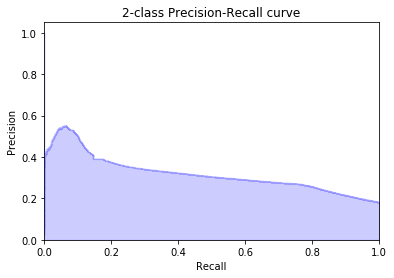

In [247]:
# pr-curve
# Note: this implementation is restricted to the binary classification task.
# Note: Parameter probas_pred can be Estimated probabilities or decision function.

precision, recall, thresholds = precision_recall_curve(y_train, yDF)
# precision_recall_curve(y_train, yScore[:, 1])
    


plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve')

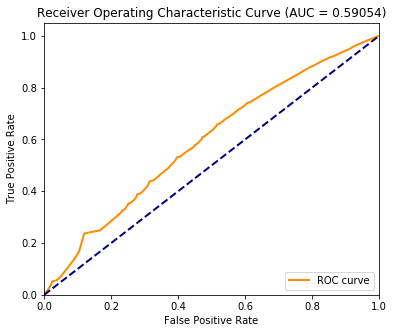

In [31]:
# roc_curve & auc
# Compute Receiver operating characteristic (ROC)
# Note: this implementation is restricted to the binary classification task.
# If labels are not binary, pos_label should be explicitly given.
fpr, tpr, thresholds = roc_curve(y_train, yScore[:,1])
auc(fpr, tpr)

plt.figure(figsize=(6,5))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve (AUC = %.5f)'% roc_auc_score(y_train, yScore[:,1]))
plt.legend(loc="lower right")
plt.show()
# plt.savefig('ROC_Curve_Baseline_3_1.png')

In [52]:
print u'训练集准确度：%.5f' % (np.mean(yHat == y_train))
print u'训练集AUC：%.5f'% roc_auc_score(y_train, yScore[:,1])
print classification_report(y_train, yHat)

print u'验证集准确度：%.2f' % (np.mean(y_testHat == y_test))
print u'验证集AUC：%.5f'% roc_auc_score(y_test, y_testScore[:,1])
print classification_report(y_test, y_testHat)

训练集准确度：0.81939
训练集AUC：0.58095
             precision    recall  f1-score   support

          0       0.82      1.00      0.90    413775
          1       0.00      0.00      0.00     91202

avg / total       0.67      0.82      0.74    504977

验证集准确度：0.82
验证集AUC：0.58032
             precision    recall  f1-score   support

          0       0.82      1.00      0.90    176951
          1       0.00      0.00      0.00     39468

avg / total       0.67      0.82      0.74    216419



/Users/fanghan/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## Baseline Model 2: GBDT

In [119]:
# GBDT Training Baseline
def GBDTFit(alg, X, y, performCV=False, printFeatureImportance=False, cv_folds=5):
    #Fit the algorithm on the data
    timeStart = time.time()
    alg.fit(X, y)
    print("Training Time: {:.2f} seconds".format(time.time() - timeStart))
    
    #Predict training set:
    dtrain_predictions = alg.predict(X)
    dtrain_predprob = alg.predict_proba(X)[:,1]
    
    #Perform cross-validation:
    if performCV:
        cv_score = cross_validation.cross_val_score(alg, X, y, cv=cv_folds, scoring='roc_auc')
    
    #Print model report:
    print "Accuracy : %.4g" % metrics.accuracy_score(y, dtrain_predictions)
    print "AUC Score (Train): %f" % metrics.roc_auc_score(y, dtrain_predprob)
    
    if performCV:
        print "CV Score : Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score))
                
    #Print Feature Importance:
#     if printFeatureImportance:
#         feat_imp = pd.Series(alg.feature_importances_, predictors).sort_values(ascending=False)
#         feat_imp.plot(kind='bar', title='Feature Importances')
#         plt.ylabel('Feature Importance Score')

In [101]:
print np.shape(X_train)[0] * 0.01

5049.77


In [443]:
# GBDT
gbm1 = GradientBoostingClassifier(random_state=0)
# gbm1 = GradientBoostingClassifier(learning_rate=0.1, n_estimators=80, max_depth=5, \
#                                   min_samples_split=5000, min_samples_leaf=500,\
#                                   max_features='sqrt', subsample=0.8,\
#                                  random_state=0)
timeStart = time.time()
gbm1.fit(X_train, y_train)
print("Time: {:.2f} seconds".format(time.time() - timeStart))
# GBDTFit(gbm1, X_train, y_train)
print gbm1
yHat = gbm1.predict(X_train)
yScore = gbm1.predict_proba(X_train)
y_testHat = gbm1.predict(X_test)
y_testScore = gbm1.predict_proba(X_test)
print roc_auc_score(y_train, yScore[:,1:])
print roc_auc_score(y_test, y_testScore[:,1:])

Time: 483.50 seconds
GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=0, subsample=1.0, verbose=0,
              warm_start=False)
0.800408942789
0.794718944432


In [156]:
# 10-folds training and testing 
# Implementation Classifier supported LR, GBDT
def Classifier(xt1, xt2, yt1, yt2, seed=0, modeltype=GradientBoostingClassifier, parmodel = {}):
    timestart = time.time()
    par.update(parmodel)
    model = modeltype(**par)
    model.fit(xt1, yt1.flatten())
    score = Score(yt2, model.predict_proba(xt2)[:,1:])
    print("Time: {:.2f} seconds".format(time.time() - timestart))
    return(model)

irxL = Kfolds(irx, 10)
par = dict(random_state=0)
# par = dict(learning_rate=0.1, n_estimators=80, max_depth=5, \
#            min_samples_split=5000, min_samples_leaf=500,\
#            max_features='sqrt', subsample=0.8,\
#            random_state=0)
modelL = CrossTrain(X, y, irxL, fmodel=Classifier, parmodel = par)
yt2pL = CrossValid(X, y, irxL, modelL)
score_mean = np.mean(CrossScore(y, [yt2pL], irxL))
score_std = np.std(CrossScore(y, [yt2pL], irxL))
# print modelL
# print yt2pL
print score_mean, score_std

Score: 0.7902
Time: 362.69 seconds
Score: 0.7923
Time: 362.83 seconds
Score: 0.7908
Time: 401.14 seconds
Score: 0.7939
Time: 390.91 seconds
Score: 0.7903
Time: 359.00 seconds
Score: 0.7936
Time: 355.35 seconds
Score: 0.7903
Time: 356.02 seconds
Score: 0.7943
Time: 395.27 seconds
Score: 0.7937
Time: 354.03 seconds
Score: 0.7890
Time: 354.81 seconds
Score: 0.7902
Score: 0.7923
Score: 0.7908
Score: 0.7939
Score: 0.7903
Score: 0.7936
Score: 0.7903
Score: 0.7943
Score: 0.7937
Score: 0.7890
Score: 0.7902
Score: 0.7923
Score: 0.7908
Score: 0.7939
Score: 0.7903
Score: 0.7936
Score: 0.7903
Score: 0.7943
Score: 0.7937
Score: 0.7890
0.791838469478 0.00184738715817


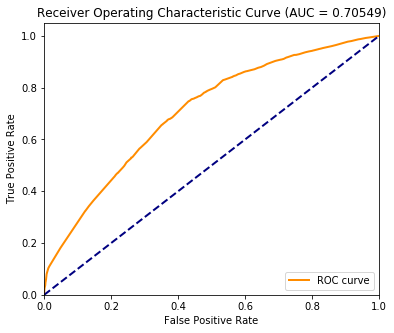

In [55]:
# yDF = LR.decision_function(X_train)
yHat = gbm0.predict(X_train)
yScore = gbm0.predict_proba(X_train)
y_testHat = gbm0.predict(X_test)
y_testScore = gbm0.predict_proba(X_test)

fpr, tpr, thresholds = roc_curve(y_train, yScore[:,1])
auc(fpr, tpr)

plt.figure(figsize=(6,5))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve (AUC = %.5f)'% roc_auc_score(y_train, yScore[:,1]))
plt.legend(loc="lower right")
plt.show()
# plt.savefig('ROC_Curve_Baseline_3_1_GBDT.png')

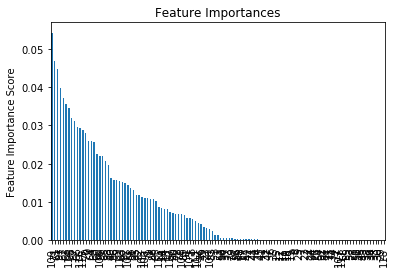

In [54]:
# 3.2 + GBDT调参
# baseline ok
feat_imp = pd.Series(gbm1.feature_importances_, list(df_train_f.iloc[:,:-1].columns)).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')

In [27]:
# ## Step 1- Find the number of estimators for a high learning rate

# We will use the following benchmarks for parameters:
# 1. min_samples_split = 500 : ~0.5-1% of total values. Since this is imbalanced class problem, we'll take small value
# 2. min_samples_leaf = 50 : Just using for preventing overfitting. will be tuned later.
# 3. max_depth = 8 : since high number of observations and predictors, choose relatively high value
# 4. max_features = 'sqrt' : general thumbrule to start with
# 5. subsample = 0.8 : typically used value (will be tuned later)

# 0.1 is assumed to be a good learning rate to start with. Let's try to find the optimum number of estimators requried for this.
print np.shape(X_train)[0]
print np.shape(X_train)[0] * 0.005
print np.shape(X_train)[0] * 0.01

# min_ samples_ split=500: 这个值应该在总样本数的0.5-1%之间，由于我们研究的是不均等分类问题，我们可以取这个区间里一个比较小的数，500。
# min_ samples_ leaf=50: 可以凭感觉选一个合适的数，只要不会造成过度拟合。同样因为不均等分类的原因，这里我们选择一个比较小的值。
# max_ depth=8: 根据观察数和自变量数，这个值应该在5-8之间。这里我们的数据有87000行，49列，所以我们先选深度为8。
# max_ features=’sqrt’: 经验上一般都选择平方根。
# subsample=0.8: 开始的时候一般就用0.8

504977
2524.885
5049.77


In [56]:
# Choose all predictors except target & IDcols
param_test1 = {'n_estimators':range(20,101,10)}
gsearch1 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, min_samples_split=2500,
                                  min_samples_leaf=250,max_depth=8,max_features='sqrt', subsample=0.8, random_state=10), 
                       param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch1.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=8,
              max_features='sqrt', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=250, min_samples_split=2500,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=10, subsample=0.8, verbose=0,
              warm_start=False),
       fit_params={}, iid=False, n_jobs=4,
       param_grid={'n_estimators': [20, 30, 40, 50, 60, 70, 80, 90, 100]},
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=0)

In [57]:
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_
# 如果给出的输出是20，可能就要降低我们的learning rate到0.05，然后再搜索一遍。
# 如果输出值太高，比如100，因为调节其他参数需要很长时间，这时候可以把learniing rate稍微调高一点。

([mean: 0.68943, std: 0.00179, params: {'n_estimators': 20},
  mean: 0.69730, std: 0.00146, params: {'n_estimators': 30},
  mean: 0.70053, std: 0.00072, params: {'n_estimators': 40},
  mean: 0.70365, std: 0.00080, params: {'n_estimators': 50},
  mean: 0.70565, std: 0.00111, params: {'n_estimators': 60},
  mean: 0.70715, std: 0.00108, params: {'n_estimators': 70},
  mean: 0.70873, std: 0.00082, params: {'n_estimators': 80},
  mean: 0.71053, std: 0.00099, params: {'n_estimators': 90},
  mean: 0.71242, std: 0.00092, params: {'n_estimators': 100}],
 {'n_estimators': 100},
 0.7124211071424632)

In [58]:
# Choose all predictors except target & IDcols
param_test1 = {'n_estimators':range(20,101,10)}
gsearch1_1 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.3, min_samples_split=2500,
                                  min_samples_leaf=250,max_depth=8,max_features='sqrt', subsample=0.8, random_state=10), 
                       param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
timeStart = time.time()
gsearch1_1.fit(X_train, y_train)
print("Grid-Searching Time: {:.2f} seconds".format(time.time() - timeStart))

Grid-Searching Time: 1781.94 seconds


In [59]:
gsearch1_1.grid_scores_, gsearch1_1.best_params_, gsearch1_1.best_score_

([mean: 0.70245, std: 0.00308, params: {'n_estimators': 20},
  mean: 0.70915, std: 0.00193, params: {'n_estimators': 30},
  mean: 0.71377, std: 0.00146, params: {'n_estimators': 40},
  mean: 0.71738, std: 0.00146, params: {'n_estimators': 50},
  mean: 0.71998, std: 0.00127, params: {'n_estimators': 60},
  mean: 0.72206, std: 0.00113, params: {'n_estimators': 70},
  mean: 0.72377, std: 0.00080, params: {'n_estimators': 80},
  mean: 0.72477, std: 0.00084, params: {'n_estimators': 90},
  mean: 0.72580, std: 0.00071, params: {'n_estimators': 100}],
 {'n_estimators': 100},
 0.7257955888191656)

In [44]:
# Grid seach on subsample and max_features
param_test2 = {'max_depth':range(5,16,1), 'min_samples_split':range(2000,5001,500)}
gsearch2 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.4, n_estimators=100,
                                                max_features='sqrt', subsample=0.8, random_state=10), 
                       param_grid = param_test2, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
timeStart = time.time()
gsearch2.fit(X_train, y_train)
print("Grid-Searching Time: {:.2f} seconds".format(time.time() - timeStart))

Grid-Searching Time: 33233.72 seconds


In [45]:
gsearch2.grid_scores_, gsearch2.best_params_, gsearch2.best_score_

([mean: 0.80714, std: 0.00107, params: {'min_samples_split': 2000, 'max_depth': 5},
  mean: 0.80710, std: 0.00113, params: {'min_samples_split': 2500, 'max_depth': 5},
  mean: 0.80680, std: 0.00148, params: {'min_samples_split': 3000, 'max_depth': 5},
  mean: 0.80667, std: 0.00192, params: {'min_samples_split': 3500, 'max_depth': 5},
  mean: 0.80675, std: 0.00130, params: {'min_samples_split': 4000, 'max_depth': 5},
  mean: 0.80586, std: 0.00158, params: {'min_samples_split': 4500, 'max_depth': 5},
  mean: 0.80581, std: 0.00158, params: {'min_samples_split': 5000, 'max_depth': 5},
  mean: 0.81001, std: 0.00097, params: {'min_samples_split': 2000, 'max_depth': 6},
  mean: 0.81008, std: 0.00129, params: {'min_samples_split': 2500, 'max_depth': 6},
  mean: 0.80924, std: 0.00154, params: {'min_samples_split': 3000, 'max_depth': 6},
  mean: 0.80927, std: 0.00139, params: {'min_samples_split': 3500, 'max_depth': 6},
  mean: 0.80895, std: 0.00143, params: {'min_samples_split': 4000, 'max_dept

## Generate TestSet

In [278]:
df_train_11 = genTrainSet('11', '12')
df_test_f = df_train_11

prices_cat value_counts:
(-1, 0]          92859
(500, 1000]      49774
(200, 400]       40770
(400, 500]       38303
(1500, 2000]     31654
(100, 200]       28936
(0, 100]         27346
(3000, 40000]    21788
(2000, 3000]     18660
(1000, 1500]     10608
Name: prices_cat11, dtype: int64
maximum of salestimediff: 4687.0
maximum year of salestimediff: 14
salestimediff_bin: [-1, 0, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330, 360, 390, 420, 450, 480, 510, 540, 570, 600, 630, 660, 690, 720, 750, 780, 810, 840, 870, 900, 930, 960, 990, 1020, 1050, 1080, 1440, 1800, 2160, 2520, 2880, 3240, 3600, 3960, 4320, 4680, 5040]
salestimediff_cat value_counts:
(1080, 1440]    32092
(780, 810]      23434
(480, 510]      19945
(1800, 2160]    16772
(1020, 1050]    13941
(420, 450]      13624
(1440, 1800]    10653
(60, 90]         9098
(930, 960]       8274
(540, 570]       7302
(750, 780]       6314
(600, 630]       6047
(630, 660]       4715
(300, 330]       3630
(720, 750]       3382
(2160, 252

In [283]:
df_test_f.columns

Index([u'net', u'age_17岁以下', u'age_18-22', u'age_23-25', u'age_26-29',
       u'age_30-39', u'age_40-49', u'age_50-59', u'age_60以上', u'age_未知',
       ...
       u'salestimediff_cat_(1800, 2160]', u'salestimediff_cat_(2160, 2520]',
       u'salestimediff_cat_(2520, 2880]', u'salestimediff_cat_(2880, 3240]',
       u'salestimediff_cat_(3240, 3600]', u'salestimediff_cat_(3600, 3960]',
       u'salestimediff_cat_(3960, 4320]', u'salestimediff_cat_(4320, 4680]',
       u'salestimediff_cat_(4680, 5040]', u'Flag'],
      dtype='object', length=121)

In [287]:
m, n = np.shape(df_test_f)
testX = df_test_f.iloc[:, :(n-2)].values
testy = df_test_f.iloc[:, -1].values

In [288]:
testyHat = LR.predict(testX)
testyScore = LR.predict_proba(testX)
print u'测试集准确度：%.2f' % (np.mean(testyHat == testy)) 
print u'测试集AUC：%.5f'% roc_auc_score(testy, testyScore[:,1])
print classification_report(testy, testyHat)

测试集准确度：0.74
测试集AUC：0.66910
             precision    recall  f1-score   support

          0       0.74      1.00      0.85    267431
          1       0.64      0.01      0.03     93267

avg / total       0.72      0.74      0.64    360698



In [55]:
dfSelCol(df_me_piv, '09').reset_index().groupby(['brand09', 'type09']).count().sort_values(by='imsi', ascending=False)

imsi
brand09   type09                  
苹果        A1429              10008
          A1586               8688
          A1332               8510
          A1528               7557
          A1524               7225
          A1530               6972
          iPhone 4S (A1387)   5348
小米        2013062             3803
          2013029             2862
          2013012             2677
CINTERION AHS3-W              2557
三星        GT-I9300            2038
小米        2013023             1997
          2014021             1996
三星        SM-G7106            1970
          GT-N7100            1889
诺基亚       Nokia 1050          1714
三星        GT-I9500            1608
苹果        A1526               1486
三星        SM-N9002            1467
          GT-I8552            1442
小米        2013022             1348
三星        GT-N7102            1276
小米        2014215             1264
          2014719             1237
          2013061             1193
三星        GT-S7572            1134
小米        2014811             1128
三星        SM-N9006            1124
宏达        HTC D516w           1078
...                            ...
三星        GT-N7102i              1
          GT-I9250T              1
          GT-I9190               1
          GT-I9100M              1
          GT-I9070P              1
          GT-I9020A              1
          SC-04F                 1
          SGH-E250i              1
          SGH-I717               1
          SGH-I727               1
          SM-G710L               1
          SM-G530Y               1
          SM-A500YZ              1
          SM-A500S               1
          SHW-M420K              1
          SHW-M290S              1
          SHW-M290K              1
          SHW-M200S              1
          SHW-M190S              1
          SHV-E470S              1
          SHV-E310S              1
          SHV-E270S              1
          SHV-E270L              1
          SHV-E170L              1
          SGH-i727               1
          SGH-i637               1
          SGH-I997R              1
          SGH-I957M              1
          SGH-I777               1
龙士康       B318                   1

[12450 rows x 1 columns]